In [2]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn .preprocessing import Imputer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

## LOAD THE DATASET AND ADD HEADERS

In [58]:
# Import the dataset and give the column names
Reviews_df=pd.read_csv('Reviews.csv')

In [59]:
Reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [60]:
Reviews_df.drop('Time',axis=1,inplace=True)

In [61]:
Reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 9 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(4), object(5)
memory usage: 28.2+ MB


In [62]:
#Check the number of rows and columns
rows,columns=Reviews_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  568454
Number of columns:  9


In [63]:
#Check the datatypes
Reviews_df.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Summary                   object
Text                      object
dtype: object

In [64]:
#Taking subset of the dataset
Reviews_df1=Reviews_df.iloc[:50000,0:]

In [65]:
Reviews_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
Id                        50000 non-null int64
ProductId                 50000 non-null object
UserId                    50000 non-null object
ProfileName               49997 non-null object
HelpfulnessNumerator      50000 non-null int64
HelpfulnessDenominator    50000 non-null int64
Score                     50000 non-null int64
Summary                   49998 non-null object
Text                      50000 non-null object
dtypes: int64(4), object(5)
memory usage: 2.5+ MB


In [66]:
#Summary statistics of rating variable
Reviews_df1['Score'].describe().transpose()

count    50000.000000
mean         4.145840
std          1.325596
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: Score, dtype: float64

In [67]:
#Find the minimum and maximum ratings
print('Minimum score is: %s' %(Reviews_df1.Score.min()))
print('Maximum score is: %s' %(Reviews_df1.Score.max()))

Minimum score is: 1
Maximum score is: 5


## Handling Missing values

In [68]:
#Check for missing values
print('Number of missing values across columns: \n',Reviews_df.isnull().sum())

Number of missing values across columns: 
 Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Summary                   27
Text                       0
dtype: int64


In [75]:
Reviews_df["Score"].fillna(Reviews_df["Score"].mean(), inplace=True)

## Ratings

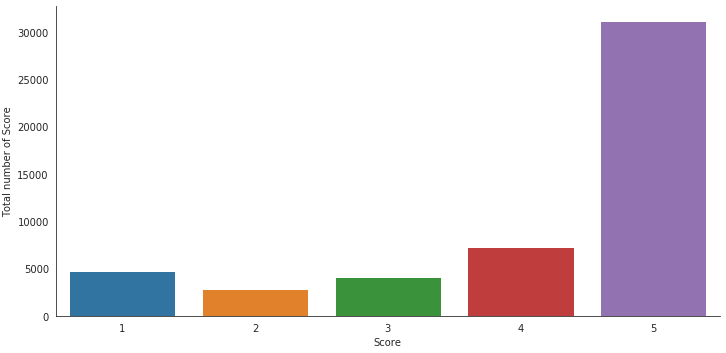

In [76]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("Score", data=Reviews_df1, aspect=2.0,kind='count')
    g.set_ylabels("Total number of Score")

## Unique users and Unique product

In [77]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', Reviews_df1['UserId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', Reviews_df1['ProductId'].nunique())

Number of unique users in Raw data =  40048
Number of unique product in Raw data =  6115


## Taking the subset of dataset to make it less sparse/ denser

In [78]:
#Check the top 10 users based on Scores
max_score=Reviews_df1.groupby('UserId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on Scores: \n',max_score)

Top 10 users based on Scores: 
 UserId
AY12DBB0U420B     44
A3OXHLG6DIBRW8    39
A1YUL9PCJR3JTY    35
A1Z54EM24Y40LL    35
A1TMAVN4CEM8U8    31
A281NPSIMI1C2R    29
A2SZLNSI5KOQJT    22
A3HPCRD9RX351S    21
A3PJZ8TU8FDQ1K    21
A31N6KB160O508    20
dtype: int64


In [79]:
counts=Reviews_df1.UserId.value_counts()
Reviews_df1_final=Reviews_df1[Reviews_df1.UserId.isin(counts[counts>=15].index)]
print('Number of users who have scored 25 or more =', len(Reviews_df1_final))
print('Number of unique users in the final data = ', Reviews_df1_final['UserId'].nunique())
print('Number of unique products in the final data = ', Reviews_df1_final['UserId'].nunique())

Number of users who have scored 25 or more = 377
Number of unique users in the final data =  15
Number of unique products in the final data =  15


## ratings analysis in final dataset

In [94]:
#constructing the pivot table
final_ratings_matrix = Reviews_df1_final.pivot(index = 'Id', columns ='ProductId', values = 'Score').fillna(0)
final_ratings_matrix.head()

ProductId,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,...,B0083QJU72,B0088OIA66,B0089SPDUW,B008FHUDW0,B008OV8RE8,B008OV91VQ,B008YAXFWI,B0092X7NGU,B0092X7OGY,B0096EZHM2
Id,,,,,,,,,,,,,,,,,,,,,
110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (377, 262)


In [96]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  377
possible_num_of_ratings =  98774
density: 0.38%


## Splitting the data

In [97]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(Reviews_df1_final, test_size = 0.3, random_state=0)
train_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text
18327,18328,B001I7PNKQ,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",1,1,5,"Herbal Alternative to Caffeinated Beverages, A...",*****<br /><br />Sweet African Green Rooibos H...
12909,12910,B0036FOV2O,AY12DBB0U420B,Gary Peterson,4,5,5,Wonderful Aroma.,I've consumed coffee ever since my youth in th...
26060,26061,B0058AMY74,A31N6KB160O508,Fran W.,0,0,4,Not bad but a little hard to get used to,My husband likes these a lot. They are a bit d...
34746,34747,B004ASFMRE,AY12DBB0U420B,Gary Peterson,0,0,5,An Excellent Snack. Rich Sunflower Seed Taste.,"Well, I discovered these little gems near the ..."
13230,13231,B0038RLIYO,A1TMAVN4CEM8U8,Gunner,0,1,2,I can't recommend this.,Ideal<br /><br />Based on my experience with i...


In [98]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (263, 9)
Shape of testing data:  (114, 9)


## Building Popularity Recommender model

In [101]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'UserId': 'score'},inplace=True)
train_data_grouped.head(40)

,ProductId,score
0,B000084EK4,1
1,B000084EK8,1
2,B000084EKA,1
3,B000084EKB,1
4,B000084EKC,1
5,B000084EKG,1
6,B00008JOL0,1
7,B0000A0BS8,1
8,B0000VLU0I,1
9,B000121BY6,1


In [103]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'ProductId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,ProductId,score,rank
174,B0058AMY74,8,1.0
148,B003VXFK44,6,2.0
180,B006N3IG4K,6,3.0
150,B0041NYV8E,5,4.0
158,B0049ZCF9G,5,5.0


In [104]:
# Use popularity based recommender model to make predictions
def recommend(User_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['UserId'] = User_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [88]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the UserId: %d\n" %(i))
    print(recommend(i))    
    print("\n")

The list of recommendations for the UserId: 10

     UserId   ProductId  score  rank
174      10  B0058AMY74      8   1.0
148      10  B003VXFK44      6   2.0
180      10  B006N3IG4K      6   3.0
150      10  B0041NYV8E      5   4.0
158      10  B0049ZCF9G      5   5.0


The list of recommendations for the UserId: 100

     UserId   ProductId  score  rank
174     100  B0058AMY74      8   1.0
148     100  B003VXFK44      6   2.0
180     100  B006N3IG4K      6   3.0
150     100  B0041NYV8E      5   4.0
158     100  B0049ZCF9G      5   5.0


The list of recommendations for the UserId: 150

     UserId   ProductId  score  rank
174     150  B0058AMY74      8   1.0
148     150  B003VXFK44      6   2.0
180     150  B006N3IG4K      6   3.0
150     150  B0041NYV8E      5   4.0
158     150  B0049ZCF9G      5   5.0




## Building Collaborative Filtering recommender model

In [105]:
Reviews_df_CF = pd.concat([train_data, test_data]).reset_index()
Reviews_df_CF.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text
0,18327,18328,B001I7PNKQ,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",1,1,5,"Herbal Alternative to Caffeinated Beverages, A...",*****<br /><br />Sweet African Green Rooibos H...
1,12909,12910,B0036FOV2O,AY12DBB0U420B,Gary Peterson,4,5,5,Wonderful Aroma.,I've consumed coffee ever since my youth in th...
2,26060,26061,B0058AMY74,A31N6KB160O508,Fran W.,0,0,4,Not bad but a little hard to get used to,My husband likes these a lot. They are a bit d...
3,34746,34747,B004ASFMRE,AY12DBB0U420B,Gary Peterson,0,0,5,An Excellent Snack. Rich Sunflower Seed Taste.,"Well, I discovered these little gems near the ..."
4,13230,13231,B0038RLIYO,A1TMAVN4CEM8U8,Gunner,0,1,2,I can't recommend this.,Ideal<br /><br />Based on my experience with i...


In [106]:
# Matrix with row per 'user' and column per 'item' 
pivot_df = Reviews_df_CF.pivot(index = 'Id', columns ='ProductId', values = 'Score').fillna(0)
pivot_df.head()

ProductId,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,...,B0083QJU72,B0088OIA66,B0089SPDUW,B008FHUDW0,B008OV8RE8,B008OV91VQ,B008YAXFWI,B0092X7NGU,B0092X7OGY,B0096EZHM2
Id,,,,,,,,,,,,,,,,,,,,,
110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (377, 262)


In [109]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

ProductId,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,...,B0088OIA66,B0089SPDUW,B008FHUDW0,B008OV8RE8,B008OV91VQ,B008YAXFWI,B0092X7NGU,B0092X7OGY,B0096EZHM2,user_index
Id,,,,,,,,,,,,,,,,,,,,,
110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [110]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

ProductId,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,...,B0083QJU72,B0088OIA66,B0089SPDUW,B008FHUDW0,B008OV8RE8,B008OV91VQ,B008YAXFWI,B0092X7NGU,B0092X7OGY,B0096EZHM2
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)

In [112]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-1.69041167e-17 -1.39744331e-19 -2.36589416e-18 ... -5.13327448e-19
  -1.94476084e-19  3.81017557e-18]
 [-1.63069866e-17 -3.22911743e-19 -1.77017368e-18 ...  8.07590034e-19
  -1.58463458e-19  3.08664688e-18]
 [ 3.18295938e-18  7.61513393e-20  4.61342950e-19 ... -9.17228202e-20
   2.49349921e-20 -4.79683738e-19]
 ...
 [ 9.82482743e-18 -1.64710755e-17 -7.59598865e-18 ...  1.74578774e-18
   2.35006807e-18  4.53233501e-18]
 [ 1.22810343e-17 -2.05888444e-17 -9.49498581e-18 ...  2.18223467e-18
   2.93758509e-18  5.66541876e-18]
 [ 1.36566886e-17 -8.87512676e-20  5.88062864e-19 ...  3.18123136e-18
  -2.23347844e-20  7.25206666e-19]]


In [113]:
print('Sigma: \n',sigma)

Sigma: 
 [10.44030651 12.24744871 12.24744871 12.24744871 12.24744871 12.52996409
 12.52996409 12.88409873 14.62873884 14.62873884]


In [114]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[10.44030651  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         12.24744871  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         12.24744871  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         12.24744871  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         12.24744871  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         12.52996409
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  12.52996409  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         12.88409873  0.          0.        ]
 [ 0.          0.          0.        

In [115]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[ 8.32983863e-18 -4.07106578e-20  3.86576607e-17 ... -6.72804519e-18
  -1.93287904e-17  2.99217226e-17]
 [-2.31430048e-19 -2.14139210e-21  5.97431845e-19 ... -2.14178169e-19
   5.61700422e-19  7.69237722e-19]
 [ 5.42800735e-18 -2.40152237e-21  3.69427703e-18 ... -2.86140235e-19
  -9.40635371e-19  2.61093131e-19]
 ...
 [ 1.24505157e-17 -1.49584417e-21 -4.07225687e-18 ... -4.36295043e-19
   1.67669223e-18  8.41747700e-19]
 [-1.44535278e-19 -5.50865432e-22  4.83110215e-19 ... -7.19412320e-20
  -3.29145805e-19  4.79281881e-19]
 [ 3.23085393e-18  1.08557273e-20 -9.20310894e-18 ...  1.37606767e-18
   6.43728304e-18 -9.44289812e-18]]


In [116]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

ProductId,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,...,B0083QJU72,B0088OIA66,B0089SPDUW,B008FHUDW0,B008OV8RE8,B008OV91VQ,B008YAXFWI,B0092X7NGU,B0092X7OGY,B0096EZHM2
0,-2.931614e-33,9.695692e-36,-9.555163e-33,4.611325e-33,-1.332924e-33,4.828402e-33,-4.696604e-33,1.346620e-33,3.663021e-33,1.771004e-33,...,-8.598082e-33,9.654450e-33,-8.659493e-33,-7.618263e-35,8.581166e-33,-7.818242e-33,1.735762e-33,1.576618e-33,4.702607e-33,-7.454450e-33
1,-2.753356e-33,9.310761e-36,-9.288220e-33,4.455290e-33,-1.257306e-33,4.198425e-33,-4.624673e-33,1.306048e-33,3.551879e-33,1.477007e-33,...,-8.229783e-33,9.264257e-33,-8.323615e-33,-1.237036e-34,7.737526e-33,-6.768633e-33,1.640528e-33,1.515042e-33,4.536275e-33,-7.147556e-33
2,5.108624e-34,-1.758203e-36,1.745010e-33,-8.575763e-34,2.362248e-34,-8.490926e-34,8.772326e-34,-2.522483e-34,-6.695819e-34,-2.652876e-34,...,1.551873e-33,-1.754960e-33,1.564973e-33,2.429799e-35,-1.492966e-33,1.277751e-33,-3.304721e-34,-2.866885e-34,-8.527718e-34,1.344404e-33
3,2.287750e-33,-7.993058e-36,7.888484e-33,-3.962577e-33,1.079500e-33,-3.842006e-33,4.016119e-33,-1.137250e-33,-3.022172e-33,-1.310445e-33,...,7.094174e-33,-7.927238e-33,7.165530e-33,6.278792e-35,-6.992292e-33,6.361427e-33,-1.471202e-33,-1.295276e-33,-3.894843e-33,6.150403e-33
4,-1.218846e-17,-4.075032e-20,3.449655e-17,-9.547969e-19,3.477283e-18,-1.794678e-17,-4.304519e-18,3.228667e-18,-1.220106e-17,-1.267730e-17,...,4.307293e-17,-3.893518e-17,4.572737e-17,-9.340108e-18,-7.967987e-17,1.090215e-16,1.259531e-18,-5.158912e-18,-2.415657e-17,3.544649e-17


In [117]:
# Recommend the items with the highest predicted ratings

def recommend_items(UserId, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = UserId-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(UserId))
    print(temp.head(num_recommendations))

In [118]:
UserId = 4
num_recommendations = 5
recommend_items(UserId, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B006N3IG4K                  0.0      7.154188e-17
B000G6RYNE                  0.0      3.865077e-17
B0058AMY74                  0.0      3.413676e-17
B0049ZCF9G                  0.0      1.755271e-17
B003VXFK44                  0.0      1.555165e-17


In [119]:
UserId = 6
num_recommendations = 5
recommend_items(UserId, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
B0058AMY74                  0.0      4.901690e-15
B001EQ4P2I                  0.0      8.694714e-16
B005K4Q1VI                  0.0      4.107648e-16
B001EO5QZK                  0.0      3.069769e-16
B000I1RHMU                  0.0      2.780820e-16


In [120]:
UserId = 8
num_recommendations = 5
recommend_items(UserId, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
B0058AMY74                  0.0      3.909668e-15
B001EQ4P2I                  0.0      6.955771e-16
B005K4Q1VI                  0.0      3.286118e-16
B001EO5QZK                  0.0      2.455815e-16
B000I1RHMU                  0.0      2.224656e-16


In [121]:
# Actual ratings given by the users
final_ratings_matrix.head()

ProductId,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,...,B0083QJU72,B0088OIA66,B0089SPDUW,B008FHUDW0,B008OV8RE8,B008OV91VQ,B008YAXFWI,B0092X7NGU,B0092X7OGY,B0096EZHM2
Id,,,,,,,,,,,,,,,,,,,,,
110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

ProductId
B000084EK4    0.007958
B000084EK5    0.013263
B000084EK6    0.013263
B000084EK7    0.010610
B000084EK8    0.007958
dtype: float64

In [123]:
# Predicted ratings 
preds_df.head()

ProductId,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,...,B0083QJU72,B0088OIA66,B0089SPDUW,B008FHUDW0,B008OV8RE8,B008OV91VQ,B008YAXFWI,B0092X7NGU,B0092X7OGY,B0096EZHM2
0,-2.931614e-33,9.695692e-36,-9.555163e-33,4.611325e-33,-1.332924e-33,4.828402e-33,-4.696604e-33,1.346620e-33,3.663021e-33,1.771004e-33,...,-8.598082e-33,9.654450e-33,-8.659493e-33,-7.618263e-35,8.581166e-33,-7.818242e-33,1.735762e-33,1.576618e-33,4.702607e-33,-7.454450e-33
1,-2.753356e-33,9.310761e-36,-9.288220e-33,4.455290e-33,-1.257306e-33,4.198425e-33,-4.624673e-33,1.306048e-33,3.551879e-33,1.477007e-33,...,-8.229783e-33,9.264257e-33,-8.323615e-33,-1.237036e-34,7.737526e-33,-6.768633e-33,1.640528e-33,1.515042e-33,4.536275e-33,-7.147556e-33
2,5.108624e-34,-1.758203e-36,1.745010e-33,-8.575763e-34,2.362248e-34,-8.490926e-34,8.772326e-34,-2.522483e-34,-6.695819e-34,-2.652876e-34,...,1.551873e-33,-1.754960e-33,1.564973e-33,2.429799e-35,-1.492966e-33,1.277751e-33,-3.304721e-34,-2.866885e-34,-8.527718e-34,1.344404e-33
3,2.287750e-33,-7.993058e-36,7.888484e-33,-3.962577e-33,1.079500e-33,-3.842006e-33,4.016119e-33,-1.137250e-33,-3.022172e-33,-1.310445e-33,...,7.094174e-33,-7.927238e-33,7.165530e-33,6.278792e-35,-6.992292e-33,6.361427e-33,-1.471202e-33,-1.295276e-33,-3.894843e-33,6.150403e-33
4,-1.218846e-17,-4.075032e-20,3.449655e-17,-9.547969e-19,3.477283e-18,-1.794678e-17,-4.304519e-18,3.228667e-18,-1.220106e-17,-1.267730e-17,...,4.307293e-17,-3.893518e-17,4.572737e-17,-9.340108e-18,-7.967987e-17,1.090215e-16,1.259531e-18,-5.158912e-18,-2.415657e-17,3.544649e-17


In [124]:
# Average PREDICTED rating for each item
preds_df.mean().head()

ProductId
B000084EK4   -6.570649e-19
B000084EK5   -2.183441e-21
B000084EK6    2.805391e-18
B000084EK7    7.567229e-18
B000084EK8    4.215193e-20
dtype: float64

In [125]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(262, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
ProductId,,,
B000084EK4,0.007958,-6.570649e-19,0
B000084EK5,0.013263,-2.183441e-21,1
B000084EK6,0.013263,2.805391e-18,2
B000084EK7,0.010610,7.567229e-18,3
B000084EK8,0.007958,4.215193e-20,4


In [126]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.01493 



In [127]:
# Enter 'userID' and 'num_recommendations' for the user #
UserId = 9
num_recommendations = 5
recommend_items(UserId, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
B0058AMY74                  0.0      3.909668e-15
B001EQ4P2I                  0.0      6.955771e-16
B005K4Q1VI                  0.0      3.286118e-16
B001EO5QZK                  0.0      2.455815e-16
B000I1RHMU                  0.0      2.224656e-16
